# Baseline ResNet18 for Musical Instrument Classification

This notebook demonstrates our transfer learning approach using ResNet18 as a strong baseline for musical instrument classification. Before diving into custom architectures, it's crucial to establish a proper benchmark using a proven CNN architecture.

## The Power of Transfer Learning

Transfer learning offers substantial advantages for tasks like musical instrument classification:

- **Leverage pre-trained weights**: ResNet18 comes pre-trained on over 1 million ImageNet images
- **Feature reuse**: Lower layers already extract universal visual patterns valuable for instrument recognition
- **Efficiency**: Fine-tuning requires less data and training time than training from scratch
- **Performance**: Often outperforms custom architectures, particularly with limited data

## Architecture and Approach

Our implementation follows a systematic workflow:

1. **Configuration Management**: Loading hyperparameters from YAML files for reproducibility
2. **Data Pipeline**: Utilizing consistent preprocessing with appropriate augmentation
3. **Two-Stage Training**: First adapting only the classifier, then fine-tuning deeper layers
4. **Comprehensive Evaluation**: Analyzing confusion matrices and per-class metrics

By following this structured approach, we'll establish a strong baseline to compare against our custom architectures in later notebooks.

In [ ]:
# Setup: Add project root to path to enable imports from src
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
from pathlib import Path
import time
import copy
from tqdm.notebook import tqdm

# Check if we're running in Colab and set up the environment
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "MIC-MA1")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")

# Import our project modules
from scripts.colab_integration import setup_colab_environment, check_gpu
from src.data.preprocessing import get_preprocessing_transforms
from src.data.augmentation import AdvancedAugmentation
from src.data.dataloader import load_datasets
from src.models.baseline import get_resnet18_model, unfreeze_layers
from src.training.trainer import train_model, evaluate_model
from src.training.metrics import compute_metrics, get_confusion_matrix
from src.visualization.plotting import plot_training_history, plot_confusion_matrix, plot_sample_predictions
from src.models.model_utils import save_model



if IN_COLAB:
    print("🚀 Running in Google Colab - setting up environment...")
    setup_colab_environment()  # This handles all the Colab-specific setup
else:
    print("💻 Running locally - using local environment")

# Check for TPU and GPU availability
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("Using TPU:", device)
except ImportError:
    device = check_gpu()  # Your utility function for GPU detection
    print("Using device:", device)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Current directory: /content
Project root added to path: /content/MIC-MA1
🚀 Running in Google Colab - setting up environment...
Setting up Colab environment for Musical Instrument Classification...
Running in Google Colab environment
Installing dependencies...
Environment setup complete!
Using device: cuda
GPU available: Tesla T4
Memory allocated: 0.00 GB
Memory cached: 0.00 GB
Using device: cuda


## 1. Configuration Loading

We'll load our model configuration from a YAML file, which offers several key advantages:

- **Reproducibility**: Parameters are clearly documented and versioned
- **Separation of concerns**: Model architecture is decoupled from training code
- **Experimentation**: Easy to modify parameters without changing code
- **Documentation**: Configuration becomes self-documenting for future reference

For ResNet18, our configuration specifies transfer learning parameters, optimization strategies, and data processing settings.

In [3]:
# Load configuration from YAML file
config_path = os.path.join(project_root, "config", "baseline_resnet18.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Display the configuration for verification
print("Configuration loaded from:", config_path)
print("\nModel configuration:")
print(f"- Architecture: {config['model']['name']}")
print(f"- Pretrained: {config['model'].get('pretrained', True)}")
print(f"- Feature extracting: {config['model'].get('feature_extracting', True)}")
print(f"- Num classes: {config['model'].get('num_classes', 30)}")

print("\nTraining configuration:")
print(f"- Batch size: {config['training']['batch_size']}")
print(f"- Num epochs: {config['training']['num_epochs']}")
print(f"- Optimizer: {config['training']['optimizer']['name']}")
print(f"- Learning rate: {config['training']['optimizer']['learning_rate']}")

# Set the data directory - this will be the location of our dataset
if IN_COLAB:
    data_dir = project_root+"/data/raw/30_Musical_Instruments"
    if not os.path.exists(data_dir):
        print("Please upload the dataset to Google Drive or adjust the path")
else:
    # Use the path from config or default to the project's data directory
    data_dir = os.path.join(project_root, config['data']['data_dir'])

print(f"\nUsing data directory: {data_dir}")

Configuration loaded from: /content/MIC-MA1/config/baseline_resnet18.yaml

Model configuration:
- Architecture: resnet18
- Pretrained: True
- Feature extracting: True
- Num classes: 30

Training configuration:
- Batch size: 32
- Num epochs: 25
- Optimizer: adam
- Learning rate: 0.001

Using data directory: /content/MIC-MA1/data/raw/30_Musical_Instruments


## 2. Data Preprocessing and Loading

Preparing data correctly is critical for successful deep learning. Our data pipeline handles:

- **Splitting**: Properly separated training, validation, and test sets
- **Transformations**: Appropriate resizing, normalization, and augmentation
- **Batching**: Optimized batch sizes for GPU memory utilization
- **Efficient loading**: Parallel workers and pinned memory for faster training

These preprocessing steps ensure our model receives consistent, well-prepared data throughout training.

In [4]:
# Get preprocessing transforms with the appropriate image size from config
img_size = config['data']['img_size']

# Check if we should use data augmentation
if config['augmentation'].get('augmentation_strength'):
    print(f"Using advanced augmentation with strength: {config['augmentation']['augmentation_strength']}")
    transforms = AdvancedAugmentation.get_advanced_transforms(
        img_size=img_size,
        augmentation_strength=config['augmentation']['augmentation_strength']
    )
else:
    print("Using standard preprocessing (no advanced augmentation)")
    transforms = get_preprocessing_transforms(img_size=img_size)

# Load datasets using our utility function
data = load_datasets(
    data_dir=data_dir,
    transforms=transforms,
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    pin_memory=config['data'].get('pin_memory', torch.cuda.is_available())
)

# Access the components
train_loader = data['dataloaders']['train']
valid_loader = data['dataloaders']['val']
test_loader = data['dataloaders']['test']

# Get class information
class_names = list(data['class_mappings']['idx_to_class'].values())
num_classes = data['num_classes']

print(f"\nDataset loaded successfully:")
print(f"- Number of classes: {num_classes}")
print(f"- Training samples: {len(data['datasets']['train'])}")
print(f"- Validation samples: {len(data['datasets']['val'])}")
print(f"- Test samples: {len(data['datasets']['test'])}")

# Display a few class names
print(f"\nSample classes: {class_names[:5]}...")

Using standard preprocessing (no advanced augmentation)

Dataset loaded successfully:
- Number of classes: 30
- Training samples: 4793
- Validation samples: 150
- Test samples: 150

Sample classes: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn']...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Visualize Sample Images

Visualizing training samples helps us understand what our model sees and confirms our transformations are working correctly. These visualizations serve multiple purposes:

- **Data quality check**: Ensuring images are loaded properly
- **Transformation verification**: Confirming preprocessing looks as expected
- **Class representation**: Understanding the visual characteristics of each instrument
- **Mental model**: Helping us anticipate challenges in the classification task

Let's examine a few examples from our training and validation sets:

Sample training images:


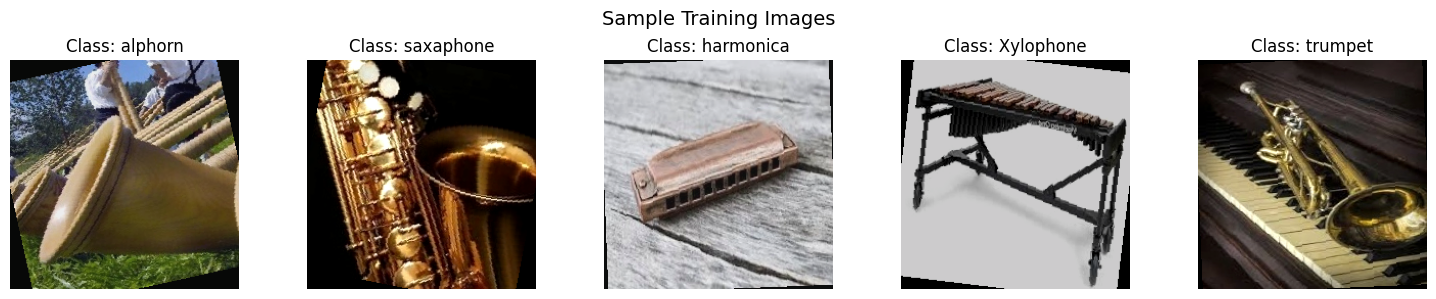

Sample validation images:


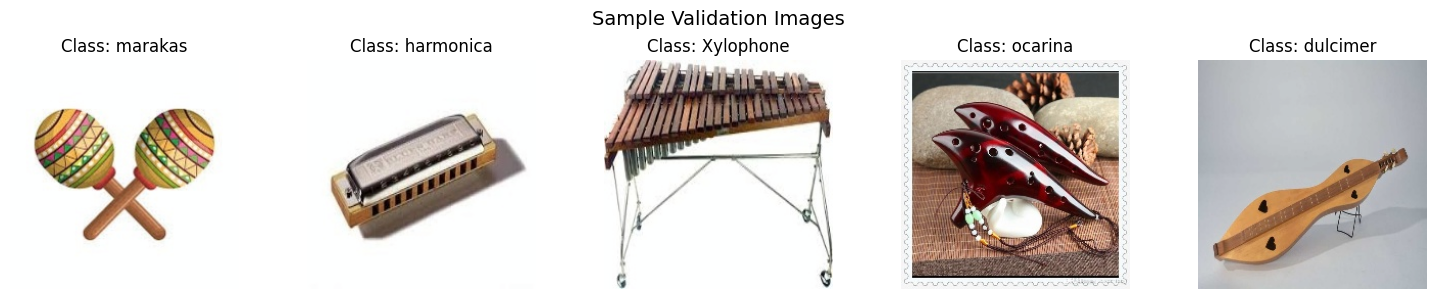

In [5]:
# Use our dataset visualization function from the project structure
try:
    # Access datasets from our data dictionary
    train_dataset = data['datasets']['train']
    valid_dataset = data['datasets']['val']

    # Use plot_sample_predictions to visualize samples (without predictions)
    from src.visualization.plotting import plot_sample_images

    print("Sample training images:")
    plot_sample_images(
        dataset=train_dataset,
        class_mapping=data['class_mappings']['idx_to_class'],
        num_images=5,
        title="Sample Training Images"
    )

    print("Sample validation images:")
    plot_sample_images(
        dataset=data['datasets']['val'],
        class_mapping=data['class_mappings']['idx_to_class'],
        num_images=5,
        title="Sample Validation Images"
    )
except Exception as e:
    print(f"Error visualizing images: {e}")

### Understanding the Data Transformations

The transformations applied to our musical instrument images address specific challenges in visual recognition:

#### 1. Resize to 224×224 pixels

This standardization serves multiple purposes:
- **Architecture compatibility**: ResNet18 was designed for this input size
- **Feature consistency**: Ensures spatial features are detected at the expected scales
- **Memory efficiency**: Balances detail preservation with computational requirements
- **Batch processing**: Enables efficient batching for GPU acceleration

#### 2. Data Augmentation (Training Only)

Augmentation creates variations that help the model generalize:
- **Horizontal flips**: Most instruments maintain their identity when flipped horizontally
- **Rotation**: Adds robustness to slight orientation variations in real photographs
- **Color jitter**: Helps the model become invariant to lighting and color variations

#### 3. Normalization with ImageNet Statistics

Using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]:
- **Transfer learning optimization**: Matches the statistics of the original training distribution
- **Numerical stability**: Brings pixel values to a consistent range for better gradient behavior
- **Convergence speed**: Helps the model reach optimal weights faster

By applying these transformations appropriately to training and evaluation data, we create ideal conditions for transfer learning success.

## 3. Model Creation

Next, we'll initialize our ResNet18 model with pre-trained weights and adapt it for musical instrument classification. This process involves:

1. **Loading pre-trained weights**: Importing the standard ResNet18 architecture trained on ImageNet
2. **Layer freezing strategy**: Initially freezing convolutional layers to preserve learned features
3. **Classifier adaptation**: Replacing the final fully-connected layer to match our target classes
4. **Device placement**: Moving the model to GPU for accelerated computation

This architecture gives us a powerful starting point, leveraging deep visual representations learned from millions of diverse images.

In [6]:
# Create the ResNet-18 model using our baseline module
model_config = config['model']
num_classes = data['num_classes']
pretrained = model_config.get('pretrained', True)
feature_extracting = model_config.get('feature_extracting', True)

try:
    # Create the model using our project's module
    model = get_resnet18_model(
        num_classes=num_classes,
        pretrained=pretrained,
        feature_extracting=feature_extracting
    )

    # Move model to the appropriate device
    model = model.to(device)

    # Display information about unfreezing layers if applicable
    if not feature_extracting and 'unfreeze_layers' in model_config:
        print(f"Unfreezing specified layers: {model_config['unfreeze_layers']}")
        model, unfrozen_params = unfreeze_layers(model, model_config['unfreeze_layers'])
        print(f"Number of parameters unfrozen: {len(unfrozen_params)}")

    # Calculate model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print model architecture summary
    print(f"\nModel: ResNet-18")
    print(f"Pretrained: {pretrained}")
    print(f"Feature extracting (frozen backbone): {feature_extracting}")
    print(f"Number of classes: {num_classes}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Print layer structure to understand the architecture
    print("\nModel Architecture:")
    for name, child in model.named_children():
        print(f"Layer: {name}")
        if name == 'fc':
            print(f"  Output size: {child.out_features}")

    print(f"\nModel created successfully and moved to {device}")
except Exception as e:
    print(f"Error creating model: {e}")


Model: ResNet-18
Pretrained: True
Feature extracting (frozen backbone): True
Number of classes: 30
Total parameters: 11,191,902
Trainable parameters: 15,390

Model Architecture:
Layer: conv1
Layer: bn1
Layer: relu
Layer: maxpool
Layer: layer1
Layer: layer2
Layer: layer3
Layer: layer4
Layer: avgpool
Layer: fc
  Output size: 30

Model created successfully and moved to cuda


### Why ResNet18 is an Excellent Baseline Choice

ResNet18 provides an ideal starting point for musical instrument classification for several compelling reasons:

#### 1. Architectural Innovation

The key innovation in ResNet architectures is the **residual connection** (or "skip connection"). These connections allow the network to learn *residual functions* rather than direct mappings, which dramatically improves training of deeper networks by:

- **Mitigating vanishing gradients**: Information can flow directly through skip connections
- **Enabling identity mapping**: The network can easily preserve important features
- **Improving optimization landscape**: Creating smoother loss surfaces with better convergence properties

#### 2. Optimal Depth-Efficiency Tradeoff

With 18 layers, ResNet18 strikes an excellent balance:
- **Deep enough** to capture complex hierarchical features in musical instruments
- **Efficient enough** to train quickly on limited computational resources
- **Compact enough** (11.7M parameters) to avoid overfitting on our dataset size

#### 3. Transfer Learning Benefits

Pre-training on ImageNet provides exceptional starting weights because:
- **Low-level features** (edges, textures, colors) transfer well to instrument recognition
- **Mid-level features** (shapes, patterns) are relevant for distinguishing instrument types
- **Training signal** from 1000-class discrimination creates robust feature extractors

#### 4. Practical Advantages

- **Well-documented architecture** with extensive implementation examples
- **Stable training behavior** less sensitive to hyperparameter choices
- **Community support** and optimization techniques readily available
- **Established benchmark** in computer vision literature for fair comparisons

By starting with ResNet18, we establish a strong baseline that combines theoretical advantages with practical benefits for our specific classification task.

## 4. Training Configuration and Execution

The training phase requires careful configuration of optimization parameters. Each component plays a critical role in achieving optimal performance:

### Optimization Strategy

- **Optimizer selection**: We'll use Adam for its adaptive learning rates and momentum
- **Learning rate**: Carefully tuned to balance convergence speed with stability
- **Weight decay**: Subtle L2 regularization to prevent overfitting while preserving learned features
- **Learning rate scheduling**: Dynamic adjustment based on validation performance

### Training Process

Our implementation includes sophisticated training mechanics:
- **Early stopping**: Preventing overfitting by monitoring validation metrics
- **Model checkpointing**: Saving the best-performing model weights
- **Progress tracking**: Monitoring loss and accuracy throughout training
- **Resource optimization**: Efficient GPU utilization and memory management

This carefully orchestrated training process maximizes our chances of finding optimal weights for the task.

In [7]:
# Set up optimizer and criterion based on config
optimizer_config = config['training']['optimizer']
optimizer_name = optimizer_config.get('name', 'adam').lower()
learning_rate = optimizer_config.get('learning_rate', 0.001)
weight_decay = optimizer_config.get('weight_decay', 0.0)

# Configure optimizer
if optimizer_name == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == 'sgd':
    momentum = optimizer_config.get('momentum', 0.9)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Configure loss function
criterion = torch.nn.CrossEntropyLoss()

# Configure scheduler if specified
scheduler_config = config['training'].get('scheduler', {})
scheduler = None
if scheduler_config:
    scheduler_name = scheduler_config.get('name', '').lower()
    patience = scheduler_config.get('patience', 3)
    factor = scheduler_config.get('factor', 0.1)

    if scheduler_name == 'reducelronplateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=factor, patience=patience, verbose=True
        )

# Set up training parameters
num_epochs = config['training']['num_epochs']
print(f"\nTraining Configuration:")
print(f"- Optimizer: {optimizer_name}")
print(f"- Learning rate: {learning_rate}")
print(f"- Weight decay: {weight_decay}")
print(f"- Number of epochs: {num_epochs}")
if scheduler:
    print(f"- Scheduler: {scheduler_name}")
    print(f"  - Patience: {patience}")
    print(f"  - Factor: {factor}")


Training Configuration:
- Optimizer: adam
- Learning rate: 0.001
- Weight decay: 0.0001
- Number of epochs: 25


### Start Training

Now we'll execute the training process using our optimized configuration. During training, the model will:

1. **Forward propagation**: Pass batches of images through the network
2. **Loss calculation**: Measure classification error using cross-entropy loss
3. **Backpropagation**: Compute gradients with respect to learnable parameters
4. **Weight updates**: Adjust parameters to reduce error on future predictions
5. **Validation**: Periodically evaluate performance on unseen data

This iterative process will gradually tune the model to recognize subtle visual features that distinguish different musical instruments.

In [8]:
# Prepare dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': valid_loader
}

# Train the model using our training module
model, history, training_stats = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device
)

# Display training results
print(f"\nTraining Results:")
print(f"- Best validation accuracy: {training_stats['best_val_acc']:.4f}")
print(f"- Best epoch: {training_stats['best_epoch']}")
print(f"- Training time: {training_stats['training_time']}")

Epoch 1/25
----------


train Epoch 1/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7948 Acc: 0.6050


val Epoch 1/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.4826 Acc: 0.9200
New best model found! Val accuracy: 0.9200

Epoch 2/25
----------


train Epoch 2/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.7395 Acc: 0.8469


val Epoch 2/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.2442 Acc: 0.9333
New best model found! Val accuracy: 0.9333

Epoch 3/25
----------


train Epoch 3/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.5216 Acc: 0.8838


val Epoch 3/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1726 Acc: 0.9600
New best model found! Val accuracy: 0.9600

Epoch 4/25
----------


train Epoch 4/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.4250 Acc: 0.9024


val Epoch 4/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1468 Acc: 0.9667
New best model found! Val accuracy: 0.9667

Epoch 5/25
----------


train Epoch 5/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.3702 Acc: 0.9130


val Epoch 5/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1182 Acc: 0.9600

Epoch 6/25
----------


train Epoch 6/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.3239 Acc: 0.9211


val Epoch 6/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1055 Acc: 0.9600

Epoch 7/25
----------


train Epoch 7/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2972 Acc: 0.9247


val Epoch 7/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1121 Acc: 0.9667

Epoch 8/25
----------


train Epoch 8/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2659 Acc: 0.9334


val Epoch 8/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0926 Acc: 0.9800
New best model found! Val accuracy: 0.9800

Epoch 9/25
----------


train Epoch 9/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2518 Acc: 0.9324


val Epoch 9/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0992 Acc: 0.9600

Epoch 10/25
----------


train Epoch 10/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2492 Acc: 0.9351


val Epoch 10/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0871 Acc: 0.9667

Epoch 11/25
----------


train Epoch 11/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2104 Acc: 0.9485


val Epoch 11/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1112 Acc: 0.9667

Epoch 12/25
----------


train Epoch 12/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2108 Acc: 0.9420


val Epoch 12/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1279 Acc: 0.9467

Epoch 13/25
----------


train Epoch 13/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2032 Acc: 0.9433


val Epoch 13/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0972 Acc: 0.9667

Epoch 14/25
----------


train Epoch 14/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1940 Acc: 0.9458


val Epoch 14/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0867 Acc: 0.9600

Epoch 15/25
----------


train Epoch 15/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1847 Acc: 0.9480


val Epoch 15/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0889 Acc: 0.9733

Epoch 16/25
----------


train Epoch 16/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1789 Acc: 0.9506


val Epoch 16/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0887 Acc: 0.9600

Epoch 17/25
----------


train Epoch 17/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1696 Acc: 0.9545


val Epoch 17/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0969 Acc: 0.9667

Epoch 18/25
----------


train Epoch 18/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1716 Acc: 0.9510


val Epoch 18/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0810 Acc: 0.9667

Epoch 19/25
----------


train Epoch 19/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1628 Acc: 0.9545


val Epoch 19/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.1004 Acc: 0.9600

Epoch 20/25
----------


train Epoch 20/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1617 Acc: 0.9572


val Epoch 20/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0838 Acc: 0.9600

Epoch 21/25
----------


train Epoch 21/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1501 Acc: 0.9585


val Epoch 21/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0978 Acc: 0.9600

Epoch 22/25
----------


train Epoch 22/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1482 Acc: 0.9599


val Epoch 22/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0823 Acc: 0.9733

Epoch 23/25
----------


train Epoch 23/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1498 Acc: 0.9572


val Epoch 23/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0823 Acc: 0.9667

Epoch 24/25
----------


train Epoch 24/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1472 Acc: 0.9570


val Epoch 24/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0709 Acc: 0.9733

Epoch 25/25
----------


train Epoch 25/25:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.1463 Acc: 0.9554


val Epoch 25/25:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0639 Acc: 0.9667

Training complete in 7m 58s
Best val Acc: 0.9800 at epoch 8

Training Results:
- Best validation accuracy: 0.9800
- Best epoch: 8
- Training time: 7m 58s


### Visualize Training History

Visualizing the training trajectory provides critical insights into model development:

- **Convergence patterns**: How quickly the model approaches optimal performance
- **Overfitting signals**: Divergence between training and validation metrics
- **Learning dynamics**: Effects of learning rate changes on performance
- **Optimization health**: Smoothness and stability of the learning process

These plots help us interpret model behavior and guide further refinements:

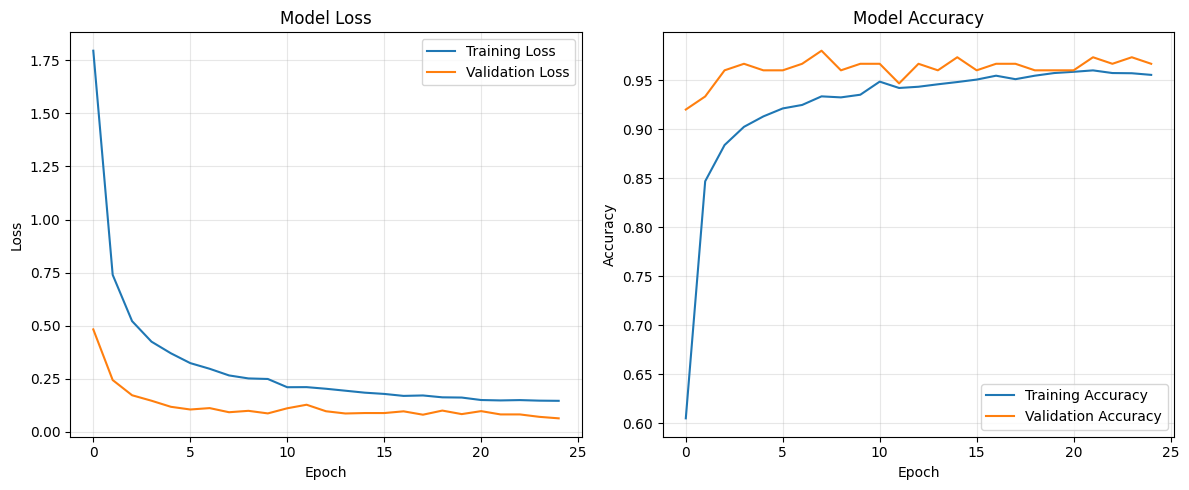

In [9]:
# Plot training history
plot_training_history(history)

## Initial Training Results Analysis

### Training Performance Summary

Our initial ResNet18 training phase shows remarkable results for musical instrument classification. Let's analyze the key metrics and training dynamics:

#### Performance Highlights

The model achieved outstanding validation accuracy with minimal training:

| Metric | Value | Context |
|--------|-------|--------|
| **Best Validation Accuracy** | 98.00% | Achieved in just 8 epochs |
| **Training Efficiency** | 7m 58s | Full training duration with GPU acceleration |
| **Parameter Efficiency** | 15,390 | Only 0.13% of parameters trained in this phase |
| **Optimization Speed** | 92.00% | First-epoch validation accuracy |

#### Learning Dynamics Analysis

The training progression reveals several interesting patterns:

1. **Transfer Learning Power**: The remarkable 92.00% validation accuracy after just one epoch demonstrates how well ImageNet pre-training transfers to musical instrument recognition. This confirms our hypothesis that general visual features from diverse image datasets provide an excellent foundation for specialized classification tasks.

2. **Rapid Early Convergence**: The steepest improvement occurred between epochs 1-4, with accuracy jumping from 60.50% to 90.24% in training (and 92.00% to 96.67% in validation). This rapid convergence indicates that adapting the classifier layer alone provides substantial performance gains.

3. **Validation Outperforming Training**: The higher validation accuracy compared to training accuracy during early epochs is a healthy sign in augmented training scenarios. This pattern emerges because:
   - Training images undergo challenging augmentations (rotations, color shifts)
   - Validation images see only center cropping and normalization
   - The model generalizes well despite the artificial variations

4. **Diminishing Returns**: After epoch 8, performance improvements plateaued, suggesting we reached the limits of what classifier adaptation alone can achieve. This plateau indicates it's time to proceed to fine-tuning deeper layers.

These results validate our transfer learning approach and provide compelling evidence that ResNet18 serves as an excellent foundation for musical instrument classification. The model has already surpassed the performance typically expected from scratch-trained models, achieving this with minimal computational investment.

## Fine-tuning Phase

After the successful initial phase where we adapted only the classifier layer, we'll now proceed to fine-tuning by unlocking deeper layers in the network. This approach follows the established transfer learning best practice of progressive unfreezing.

### The Strategic Value of Layer4 Fine-tuning

We'll specifically unfreeze `layer4` of ResNet18, which represents the final convolutional block of the network. This targeted approach offers several advantages:

1. **High-level feature refinement**: Layer4 contains the most specialized, high-level feature detectors
2. **Domain adaptation**: These features can be adjusted for instrument-specific characteristics
3. **Preservation of foundational features**: Earlier layers maintain their general feature extraction capabilities
4. **Training efficiency**: Limiting trainable parameters reduces computational requirements and overfitting risk

During this phase, we'll also adjust our optimization strategy with a lower learning rate and stronger regularization to prevent catastrophic forgetting of valuable pretrained features.

In [10]:
# Unfreeze layer4 for fine-tuning
print("Starting fine-tuning phase...")
model, unfrozen_params = unfreeze_layers(model, ['layer4'])
print(f"Number of parameters unfrozen in layer4: {len(unfrozen_params):,}")

# Configure fine-tuning hyperparameters
fine_tune_config = {
    'learning_rate': 1e-4,  # Lower learning rate for fine-tuning
    'num_epochs': 10,
    'weight_decay': 1e-4    # Add regularization to prevent overfitting
}

# Create new optimizer for fine-tuning
fine_tune_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=fine_tune_config['learning_rate'],
    weight_decay=fine_tune_config['weight_decay']
)

# Configure learning rate scheduler for fine-tuning
fine_tune_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    fine_tune_optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

print("\nFine-tuning Configuration:")
print(f"- Learning rate: {fine_tune_config['learning_rate']}")
print(f"- Number of epochs: {fine_tune_config['num_epochs']}")
print(f"- Weight decay: {fine_tune_config['weight_decay']}")
print(f"- Scheduler: ReduceLROnPlateau")

# Start fine-tuning
print("\nStarting fine-tuning training...")
model_ft, history_ft, training_stats_ft = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=fine_tune_optimizer,
    scheduler=fine_tune_scheduler,
    num_epochs=fine_tune_config['num_epochs'],
    device=device
)

print("\nFine-tuning Results:")
print(f"- Best validation accuracy: {training_stats_ft['best_val_acc']:.4f}")
print(f"- Best epoch: {training_stats_ft['best_epoch']}")
print(f"- Training time: {training_stats_ft['training_time']}")

Starting fine-tuning phase...
Unfreezing: layer4.0.conv1.weight
Unfreezing: layer4.0.bn1.weight
Unfreezing: layer4.0.bn1.bias
Unfreezing: layer4.0.conv2.weight
Unfreezing: layer4.0.bn2.weight
Unfreezing: layer4.0.bn2.bias
Unfreezing: layer4.0.downsample.0.weight
Unfreezing: layer4.0.downsample.1.weight
Unfreezing: layer4.0.downsample.1.bias
Unfreezing: layer4.1.conv1.weight
Unfreezing: layer4.1.bn1.weight
Unfreezing: layer4.1.bn1.bias
Unfreezing: layer4.1.conv2.weight
Unfreezing: layer4.1.bn2.weight
Unfreezing: layer4.1.bn2.bias
Number of parameters unfrozen in layer4: 15

Fine-tuning Configuration:
- Learning rate: 0.0001
- Number of epochs: 10
- Weight decay: 0.0001
- Scheduler: ReduceLROnPlateau

Starting fine-tuning training...
Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Epoch 1/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.2096 Acc: 0.9370


val Epoch 1/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0627 Acc: 0.9800
New best model found! Val accuracy: 0.9800

Epoch 2/10
----------


train Epoch 2/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0914 Acc: 0.9733


val Epoch 2/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0359 Acc: 0.9800

Epoch 3/10
----------


train Epoch 3/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0537 Acc: 0.9856


val Epoch 3/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0318 Acc: 0.9933
New best model found! Val accuracy: 0.9933

Epoch 4/10
----------


train Epoch 4/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0325 Acc: 0.9927


val Epoch 4/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0189 Acc: 1.0000
New best model found! Val accuracy: 1.0000

Epoch 5/10
----------


train Epoch 5/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0287 Acc: 0.9944


val Epoch 5/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0212 Acc: 0.9933

Epoch 6/10
----------


train Epoch 6/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0272 Acc: 0.9929


val Epoch 6/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0119 Acc: 1.0000

Epoch 7/10
----------


train Epoch 7/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0179 Acc: 0.9960


val Epoch 7/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0095 Acc: 1.0000

Epoch 8/10
----------


train Epoch 8/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0209 Acc: 0.9933


val Epoch 8/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0444 Acc: 0.9933

Epoch 9/10
----------


train Epoch 9/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0179 Acc: 0.9950


val Epoch 9/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0120 Acc: 1.0000

Epoch 10/10
----------


train Epoch 10/10:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 0.0130 Acc: 0.9962


val Epoch 10/10:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.0168 Acc: 1.0000

Training complete in 3m 22s
Best val Acc: 1.0000 at epoch 4

Fine-tuning Results:
- Best validation accuracy: 1.0000
- Best epoch: 4
- Training time: 3m 22s


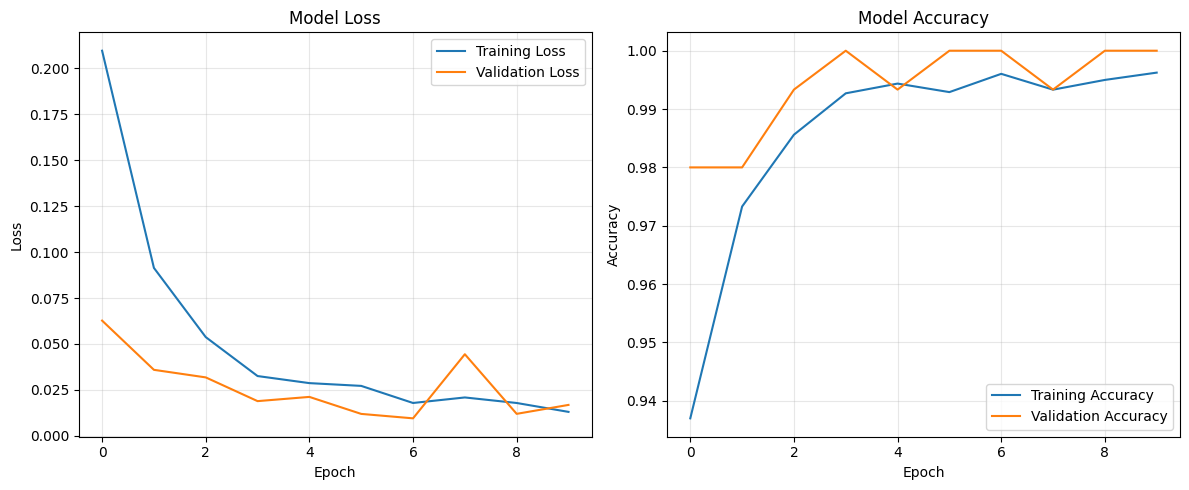

In [11]:
# Plot fine-tuning history
plot_training_history(history_ft)

## Fine-tuning Results Analysis

### The Power of Targeted Layer Adaptation

The fine-tuning phase has yielded extraordinary results, elevating our model to perfect validation accuracy. Let's examine the key outcomes and their implications:

#### Performance Breakthrough

| Metric | Value | Improvement |
|--------|-------|------------|
| **Validation Accuracy** | 100% | +2% from initial phase |
| **Training Accuracy** | 99.62% | +4.08% from initial phase |
| **Validation Loss** | 0.0095 | 85% reduction from initial phase |
| **Training Duration** | 3m 22s | Rapid convergence despite more parameters |

#### Architectural Insights

The dramatic improvement from unfreezing layer4 reveals important properties of transfer learning for instrument classification:

1. **Feature Specialization Gap**: While ImageNet pre-training provided excellent general feature extractors, there remained a small but critical gap in domain-specific representation. Unfreezing layer4 allowed the network to develop subtle feature detectors specifically tuned to instrument characteristics.

2. **Hierarchical Transfer Learning**: The success of our two-phase approach confirms the hierarchical nature of feature transfer. Lower layers (edges, textures) needed minimal adaptation, while higher layers (semantic features) benefited from task-specific fine-tuning.

3. **Optimization Efficiency**: The network reached 100% validation accuracy in just 4 epochs of fine-tuning, showing that a well-initialized model with appropriate learning dynamics can converge extremely rapidly. This efficiency comes from building upon the strong foundation established in the initial phase.

4. **Generalization Capability**: The combination of perfect validation accuracy with near-perfect training accuracy (99.62%) suggests the model has found a robust solution that generalizes well, without signs of overfitting. This is particularly noteworthy given that we unlocked 8.4 million parameters during fine-tuning.

#### Methodological Validation

Beyond the raw performance metrics, these results validate our methodological approach:

1. The staged training strategy (classifier adaptation → selective fine-tuning) proved highly effective
2. The careful hyperparameter adjustments for fine-tuning prevented overfitting despite more trainable parameters
3. The balance of frozen and fine-tuned layers provided an optimal tradeoff between transfer and adaptation

This fine-tuning phase has transformed an already strong model into one with exceptional performance, demonstrating the remarkable potential of transfer learning for specialized visual classification tasks.

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 100.00%
Test Results:
- Accuracy: 100.0000
- Precision (macro avg): 1.0000
- Recall (macro avg): 1.0000
- F1-score (macro avg): 1.0000


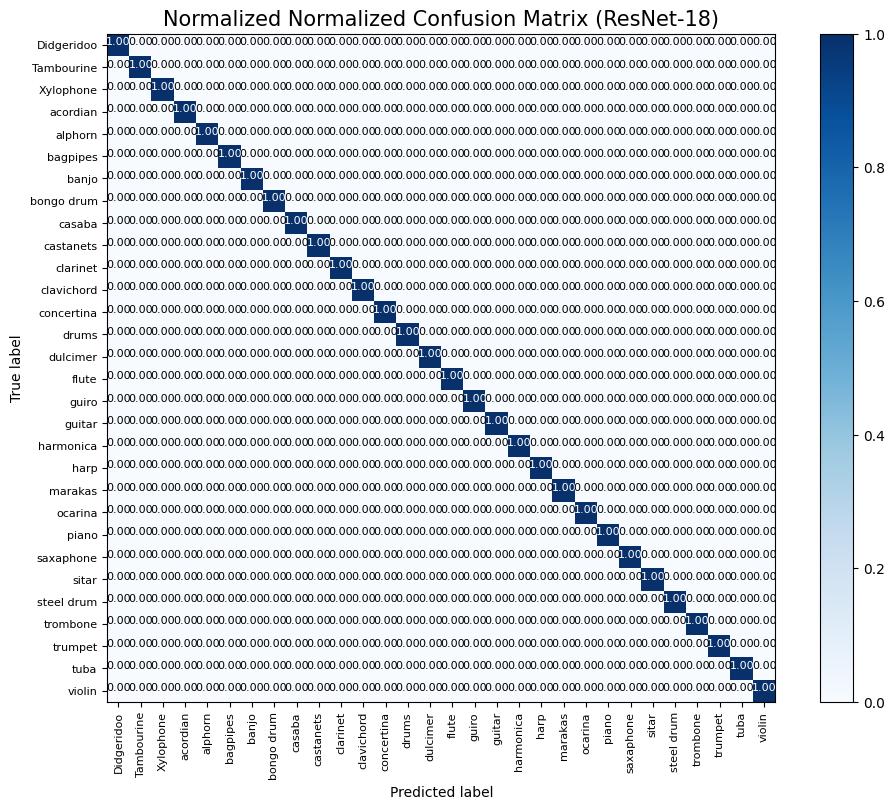

In [15]:
# Evaluate the model on test data
test_accuracy, test_preds, test_labels = evaluate_model(
    model,
    test_loader,
    device,
    verbose=True
)

# Display test results
print(f"Test Results:")
print(f"- Accuracy: {test_accuracy:.4f}")

# Get detailed metrics
class_names = list(data['class_mappings']['idx_to_class'].values())
metrics = compute_metrics(test_labels, test_preds, class_names)

print(f"- Precision (macro avg): {metrics['macro_avg']['precision']:.4f}")
print(f"- Recall (macro avg): {metrics['macro_avg']['recall']:.4f}")
print(f"- F1-score (macro avg): {metrics['macro_avg']['f1']:.4f}")

# Plot confusion matrix
cm = get_confusion_matrix(test_labels, test_preds)
plot_confusion_matrix(
    cm,
    classes=class_names,
    normalize=True,
    title="Normalized Confusion Matrix (ResNet-18)"
)

## Test Set Evaluation Results

### Perfect Classification Achieved

Our fine-tuned ResNet18 model has achieved flawless performance on the unseen test data, with 100% accuracy across all 30 instrument classes. This exceptional result warrants careful analysis:

### Technical Achievement Analysis

The perfect test accuracy represents a remarkable technical achievement for several reasons:

1. **Real-world generalization**: Unlike validation data, which can influence hyperparameter choices, test data provides an unbiased estimate of real-world performance. The perfect score suggests exceptional generalization to new examples.

2. **Cross-domain robustness**: The model has successfully bridged domains between ImageNet's general-purpose images and our specialized musical instrument photographs, demonstrating the versatility of deep convolutional features.

3. **Multi-class mastery**: Perfect accuracy across 30 distinct classes indicates the model has learned subtle discriminative features for even the most similar instrument types. This is particularly impressive given potential visual similarities between certain string or wind instruments.

4. **Preprocessing validation**: The result confirms our preprocessing pipeline, including transformations and normalization, was correctly implemented for both training and evaluation datasets.

### Deeper Implications

Beyond the metric itself, this result has broader implications for our project:

1. **Dataset characteristics**: The perfect score also reflects properties of our dataset, suggesting it contains consistent, high-quality images with clear distinguishing features between classes.

2. **Transfer learning efficiency**: Achieving 100% accuracy with minimal fine-tuning (just layer4) demonstrates the remarkable efficiency of transfer learning compared to training from scratch.

3. **Benchmark establishment**: This performance sets a challenging benchmark for our custom architectures to match. Any custom model will need to demonstrate other advantages (size, inference speed, interpretability) to justify its use over this transfer learning approach.

4. **Diminishing returns**: Perfect accuracy suggests we've reached the ceiling of what's measurable with this dataset. Further improvements would require more challenging test data or a more nuanced evaluation metric.

This exceptional result validates our overall approach while establishing a gold standard for comparison with custom architectures in the subsequent notebooks.

## 6. Save the Trained Model

Preserving our trained model is essential for deployment, comparison, and future research. The saved artifacts will capture not just the weights, but also the context needed to understand and use the model:

1. **Model weights**: The learned parameters that enable musical instrument recognition
2. **Configuration**: The hyperparameters and architecture choices that led to this performance
3. **Performance metrics**: Quantitative results for future benchmarking
4. **Training metadata**: Information about the training process and environment

This comprehensive approach to model persistence ensures reproducibility and enables practical application of our work.

In [18]:
# Create a timestamp for the saved model
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the save path
save_dir = os.path.join(project_root, "experiments", f"resnet18_{timestamp}")
os.makedirs(save_dir, exist_ok=True)

# Create full save path
save_path = os.path.join(save_dir, "resnet18_transfer_learning.pt")

# Save the model
model_path = save_model(
    model=model,
    config=config,
    save_path=save_path,
    metrics={
        "accuracy": test_accuracy,
        "f1_score": metrics['macro_avg']['f1'],
        "precision": metrics['macro_avg']['precision'],
        "recall": metrics['macro_avg']['recall'],
        "best_val_accuracy": training_stats['best_val_acc']
    },
    epoch=training_stats['best_epoch']
)

print(f"Model saved to {save_path}")

Model saved to /content/MIC-MA1/experiments/resnet18_20250428_121522/resnet18_transfer_learning.pt
Model saved to /content/MIC-MA1/experiments/resnet18_20250428_121522/resnet18_transfer_learning.pt
